Run the following code before running this script

ROAST to get Bvals

0.5_extract_sphere_data.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense


from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

import pickle
from keras.models import load_model

# Load prepared data

In [2]:
dir_path = "/Users/chikakoolsen/opt/python/thesis/code/tdcs_thesis/"
# dir_path = "/Users/mriworkshop/Documents/TDCS/code/tdcs_thesis/"
save_path = dir_path+"data/raw/"
img_path =  dir_path+"data/processed/"
model_path = dir_path+"models/"

## 5 attribute

In [ ]:
file_mean = save_path+"fmap_mean_40.txt"
columns_mean =['exp', 'mini_exp', 'i', 'j', 'k', 'mean0', 'mean1', 'mean2', 'mean3', 'mean4']
data = np.loadtxt(file_mean);

In [ ]:
df = pd.DataFrame(data, columns=columns_mean)
df = df.astype({"exp": int, "i": int, "j": int, "k": int, "mini_exp": int})
df

## 3 attributes

In [3]:
file_mean = save_path+"fmap_mean_neg_42to44.txt"
columns_mean =['exp', 'mini_exp', 'i', 'j', 'k', 'neg', 'mean0', 'mean1', 'mean2']
data = np.loadtxt(file_mean);

In [4]:
df = pd.DataFrame(data, columns=columns_mean)
df = df.astype({"exp": int, "i": int, "j": int, "k": int, "mini_exp": int, "neg": int})
df

,exp,mini_exp,i,j,k,neg,mean0,mean1,mean2
0,42,1,0,0,0,0,0.0,0.0,0.0
1,42,1,0,0,1,0,0.0,0.0,0.0
2,42,1,0,0,2,0,0.0,0.0,0.0
3,42,1,0,0,3,0,0.0,0.0,0.0
4,42,1,0,0,4,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2883579,44,3,43,63,59,1,0.0,0.0,0.0
2883580,44,3,43,63,60,1,0.0,0.0,0.0
2883581,44,3,43,63,61,1,0.0,0.0,0.0
2883582,44,3,43,63,62,1,0.0,0.0,0.0


In [8]:
df.loc[(df['i']==21)&(df['j']==38)&(df['k']==31)]

,exp,mini_exp,i,j,k,neg,mean0,mean1,mean2
88479,42,1,21,38,31,0,-414.192474,-408.864014,-400.965332
268703,42,1,21,38,31,1,-400.965332,-396.122742,-392.983704
448927,42,2,21,38,31,0,-389.405853,-389.718658,-384.057922
629151,42,2,21,38,31,1,-384.057922,-378.707153,-378.122986
809375,42,3,21,38,31,0,-375.691589,-377.150238,-372.640259
989599,42,3,21,38,31,1,-372.640259,-369.027954,-369.421661
1169823,43,1,21,38,31,0,74.168518,75.958549,77.451073
1350047,43,1,21,38,31,1,77.451073,83.136375,82.270538
1530271,43,2,21,38,31,0,85.189888,86.367722,89.208015
1710495,43,2,21,38,31,1,89.208015,91.062462,94.325844


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2883584 entries, 0 to 2883583
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   exp       int64  
 1   mini_exp  int64  
 2   i         int64  
 3   j         int64  
 4   k         int64  
 5   neg       int64  
 6   mean0     float64
 7   mean1     float64
 8   mean2     float64
dtypes: float64(3), int64(6)
memory usage: 198.0 MB


# Split data

## Get one experiment

In [9]:
df_test1 = df[(df['exp']==44) & (df['mini_exp']==1) & (df['neg']==1)]
df_test2 = df[(df['exp']==44) & (df['mini_exp']==1) & (df['neg']==0)]
df_test3 = df[(df['exp']==44) & (df['mini_exp']==2) & (df['neg']==1)]
df_test4 = df[(df['exp']==44) & (df['mini_exp']==2) & (df['neg']==0)]
# df_test5 = df[(df['exp']==44) & (df['mini_exp']==3) & (df['neg']==1)]
# df_test6 = df[(df['exp']==44) & (df['mini_exp']==3) & (df['neg']==0)]

In [10]:
print(df_test1.shape)
print(df_test2.shape)
print(df_test3.shape)
print(df_test4.shape)
# print(df_test5.shape)
# print(df_test6.shape)

(180224, 9)
(180224, 9)
(180224, 9)
(180224, 9)


In [11]:
df_test1.iloc[:, 6:]

,mean0,mean1,mean2
1982464,0.0,0.0,0.0
1982465,0.0,0.0,0.0
1982466,0.0,0.0,0.0
1982467,0.0,0.0,0.0
1982468,0.0,0.0,0.0
...,...,...,...
2162683,0.0,0.0,0.0
2162684,0.0,0.0,0.0
2162685,0.0,0.0,0.0
2162686,0.0,0.0,0.0


In [12]:
X_pred1 = df_test1.iloc[:, 6:].values 
# y_pred1 = df_test1['theory'].values

X_pred2 = df_test2.iloc[:, 6:].values 
# y_pred2 = df_test2['theory'].values

X_pred3 = df_test3.iloc[:, 6:].values 
# y_pred3 = df_test3['theory'].values

# X_pred4 = df_test4.iloc[:, 6:].values 
# # y_pred4 = df_test4['theory'].values

# X_pred5 = df_test5.iloc[:, 6:].values 
# # y_pred5 = df_test5['theory'].values

# X_pred6 = df_test6.iloc[:, 6:].values 
# # y_pred6 = df_test6['theory'].values

## None zero

In [ ]:
# 5 attributes
df_nonzero = df[(df['mean0']!=0.0) & (df['mean1']!=0.0) & (df['mean2']!=0.0) & (df['mean3']!=0.0) & (df['mean4']!=0.0)]

In [13]:
# 3 attributes
df_nonzero = df[(df['mean0']!=0.0) & (df['mean1']!=0.0) & (df['mean2']!=0.0)]

In [135]:
df_nonzero

,exp,mini_exp,i,j,k,neg,mean0,mean1,mean2
10074,42,1,2,29,26,0,-984.707153,-970.159729,-974.554504
10076,42,1,2,29,28,0,-333.152374,-270.754669,-102.585724
10137,42,1,2,30,25,0,-788.129700,-787.770996,-808.987488
10138,42,1,2,30,26,0,-1038.672119,-1019.283020,-1018.710083
13853,42,1,3,24,29,0,-352.913147,-328.458252,-345.069885
...,...,...,...,...,...,...,...,...,...
2870480,44,3,40,51,16,1,108.029625,237.504181,300.838898
2870481,44,3,40,51,17,1,104.060471,73.791672,126.305840
2870543,44,3,40,52,15,1,167.685898,155.256668,9.042796
2870605,44,3,40,53,13,1,951.931030,-87.699287,-870.282227


In [14]:
df4_pred1 =  df_nonzero[(df_nonzero['exp']==44) & (df_nonzero['mini_exp']==1) & (df_nonzero['neg']==1)]
df4_pred2 =  df_nonzero[(df_nonzero['exp']==44) & (df_nonzero['mini_exp']==1) & (df_nonzero['neg']==0)]
df4_pred3 =  df_nonzero[(df_nonzero['exp']==44) & (df_nonzero['mini_exp']==2) & (df_nonzero['neg']==1)]
df4_pred4 =  df_nonzero[(df_nonzero['exp']==44) & (df_nonzero['mini_exp']==2) & (df_nonzero['neg']==0)]
# df4_pred5 =  df_nonzero[(df_nonzero['exp']==44) & (df_nonzero['mini_exp']==3) & (df_nonzero['neg']==1)]
# df4_pred6 =  df_nonzero[(df_nonzero['exp']==44) & (df_nonzero['mini_exp']==3) & (df_nonzero['neg']==0)]

In [137]:
df4_pred1.iloc[:, 6:]

,mean0,mean1,mean2
1272389,-164.883804,-32.437187,4223.044922
1272390,-5027.678223,1026.242920,483.986450
1272391,-19.035112,-2394.353760,692.172668
1272392,-115.449661,1003.072388,585.662109
1272412,-450.681030,-436.324005,-444.340424
...,...,...,...
1428056,-319.276337,-315.796112,-327.174133
1428057,-267.923767,-267.496338,-266.819611
1428058,-339.439331,-339.289368,-340.359467
1428060,-388.100250,-362.276947,-380.388489


In [15]:
X4_pred1 = df4_pred1.iloc[:, 6:].values
# y4_pred1 = df4_pred1['theory'].values

X4_pred2 = df4_pred2.iloc[:, 6:].values
# y4_pred2 = df4_pred2['theory'].values

X4_pred3 = df4_pred3.iloc[:, 6:].values
# y4_pred3 = df4_pred3['theory'].values

X4_pred4 = df4_pred4.iloc[:, 6:].values
# X4_pred5 = df4_pred5.iloc[:, 6:].values
# X4_pred6 = df4_pred6.iloc[:, 6:].values

In [16]:
print(X4_pred1.shape)
print(X4_pred2.shape)
print(X4_pred3.shape)
print(X4_pred4.shape)
# print(X4_pred5.shape)
# print(X4_pred6.shape)

(26798, 3)
(26798, 3)
(26798, 3)
(26798, 3)


## Load model

In [ ]:
# 5 attributes
file = model_path+'model_nonzero_32to38_3layer5unit_300.sav'
model = pickle.load(open(file, 'rb'))

In [17]:
# 3 attributes
file = model_path+'best_model_nn_optimized.h5'
model = load_model(file)

2023-05-01 23:10:04.111254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Predict

In [ ]:
# GO TO Output section

In [87]:
df_test = df_test1
df_pred = df4_pred1

In [88]:
X_test = X4_pred1
# y_test = y4_pred3

In [ ]:
result = model.evaluate(X_test, y_test)
print(result)

In [ ]:
test_pred = model.predict(X_test)
print(mse(test_pred, y_test))
print(mape(test_pred, y_test))

In [ ]:
np.corrcoef(test_pred.flatten(), y_test)

# Plot

### Theory vs Predict

In [ ]:
x = y_test.flatten()
y = test_pred.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_test, test_pred,  color='black')
plt.axis([0,100, 0, 100])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
plt.title("Neural Network Prediction vs Theory", fontsize=15)
# print(r, st_er)
print("r: {:.5f}, st_er: {:.6f}".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

# Output data

## ROI

### Negative

In [51]:
test_pred1 = model.predict(X_pred1)

250/250 [==============================] - 0s 725us/step


In [52]:
y_pred = y_pred1
test_pred = test_pred1

r: 0.90747, st_er: 0.005843
y = 1.1288*x + 2.9513


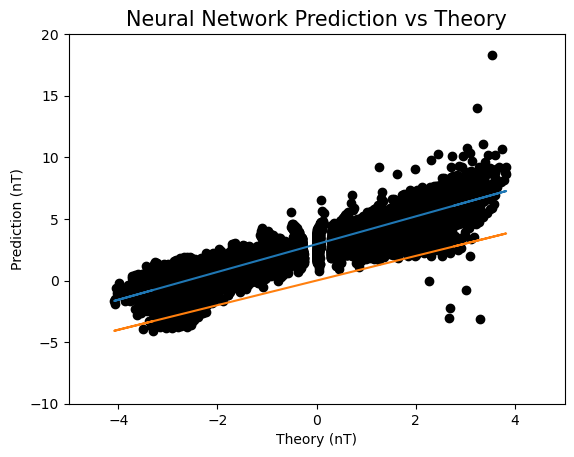

In [56]:
x = y_pred.flatten()
y = test_pred.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_pred, test_pred,  color='black')
plt.axis([-5, 5, -10, 20])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
plt.title("Neural Network Prediction vs Theory", fontsize=15)
# print(r, st_er)
print("r: {:.5f}, st_er: {:.6f}".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

### Positive

In [57]:
test_pred2 = model.predict(X_pred2)

250/250 [==============================] - 0s 797us/step


In [58]:
y_pred = y_pred2
test_pred = test_pred2

r: 0.92673, st_er: 0.003850
y = 0.8494*x + 1.425


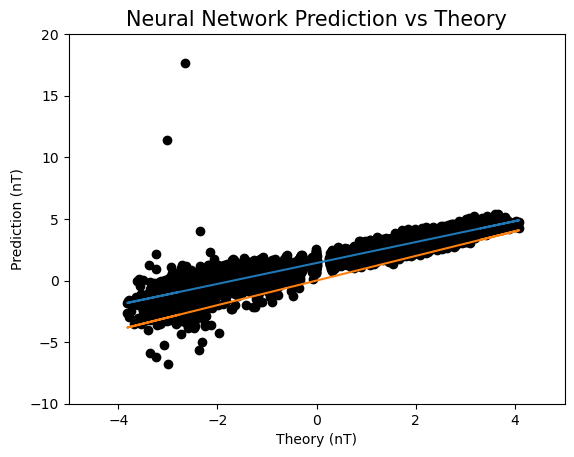

In [59]:
x = y_pred.flatten()
y = test_pred.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_pred, test_pred,  color='black')
plt.axis([-5, 5, -10, 20])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
plt.title("Neural Network Prediction vs Theory", fontsize=15)
# print(r, st_er)
print("r: {:.5f}, st_er: {:.6f}".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

In [60]:
df_test1['predict'] = test_pred1
df_test2['predict'] = test_pred2

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_30393/1578999380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['predict'] = test_pred1
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_30393/1578999380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test2['predict'] = test_pred2


In [61]:
np.savetxt(img_path+"nn_optimized_43_1_neg.txt", df_test1[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")
np.savetxt(img_path+"nn_optimized_43_1_pos.txt", df_test2[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

#### Detrend vs Theory

In [65]:
detrend = df_test2['detrend'].values
y_pred = df_test2['theory'].values

r: 0.95367, st_er: 0.002618
y = 0.7421*x + 0.1522


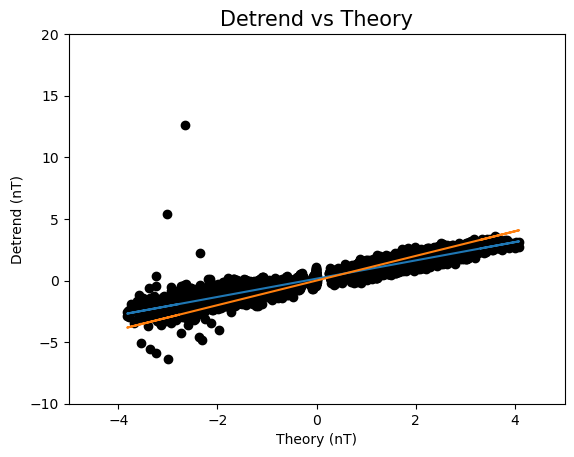

In [66]:
x = y_pred.flatten()
y = detrend.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_pred, detrend,  color='black')
plt.axis([-5, 5, -10, 20])
plt.xlabel("Theory (nT)")
plt.ylabel("Detrend (nT)")
plt.title("Detrend vs Theory", fontsize=15)
# print(r, st_er)
print("r: {:.5f}, st_er: {:.6f}".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))

## No ROI

In [18]:
df_test = df_test3
df_pred = df4_pred3

In [19]:
X_test = X4_pred3

In [20]:
test_pred = model.predict(X_test)

838/838 [==============================] - 2s 764us/step


In [21]:
df_pred['predict'] = test_pred

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_5375/255584968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['predict'] = test_pred


In [22]:
df_test['predict'] = 0.00

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_5375/3257651465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = 0.00


In [160]:
# 5 attributes
df_out = df_test[['i', 'j', 'k', 'predict']]
df_pre = df_pred[['i', 'j', 'k', 'predict']]

In [23]:
# 3 attributes
df_out = df_test[['i', 'j', 'k', 'neg', 'predict']]
df_pre = df_pred[['i', 'j', 'k', 'neg', 'predict']]

In [162]:
# 5 attributes
for x in range(len(df_pre)):
    i = df_pre.iloc[x, :]['i'].astype(int)
    j = df_pre.iloc[x, :]['j'].astype(int)
    k = df_pre.iloc[x, :]['k'].astype(int)
    pred = df_pre.iloc[x, :]['predict']
    idx = df_out[(df_out['i']==i) & (df_out['j']==j) & (df_out['k']==k)].index
    df_out.loc[idx, 'predict']= pred

In [24]:
# 3 attributes
for x in range(len(df_pre)):
    i = df_pre.iloc[x, :]['i'].astype(int)
    j = df_pre.iloc[x, :]['j'].astype(int)
    k = df_pre.iloc[x, :]['k'].astype(int)
    neg = df_pre.iloc[x, :]['neg'].astype(int)
    pred = df_pre.iloc[x, :]['predict']
    idx = df_out[(df_out['i']==i) & (df_out['j']==j) & (df_out['k']==k) & (df_out['neg']==neg)].index
    df_out.loc[idx, 'predict']= pred

In [102]:
df_out

,i,j,k,neg,predict
1802240,0,0,0,0,0.0
1802241,0,0,1,0,0.0
1802242,0,0,2,0,0.0
1802243,0,0,3,0,0.0
1802244,0,0,4,0,0.0
...,...,...,...,...,...
1982459,43,63,59,0,0.0
1982460,43,63,60,0,0.0
1982461,43,63,61,0,0.0
1982462,43,63,62,0,0.0


In [164]:
# 5 attributes
np.savetxt(img_path+"nn_nonzero_neg_40_7_pos_erode_cly_2.txt", df_out[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [116]:
# 3 attributes
# df_pos = df_out[df_out['neg']==0]
# df_neg = df_out[df_out['neg']==1]
# np.savetxt(img_path+"nn_nonzero_neg_40_1_pos_erode_cly.txt", df_pos[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")
# np.savetxt(img_path+"nn_nonzero_neg_40_1_neg_erode_cly.txt", df_neg[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [25]:
# New 3 attributes
np.savetxt(img_path+"nn_nonzero_best_cly_44_2_neg_2.txt", df_out[['i', 'j', 'k', 'predict']], fmt="%i %i %i %s")

In [115]:
df4_pred1['theory']

,exp,mini_exp,i,j,k,amp,neg,mean0,mean1,mean2,theory,predict
190298,42,1,2,29,26,2,1,-974.554504,-988.312378,-973.724548,0.798312,-10.822295
190300,42,1,2,29,28,2,1,-102.585724,-143.370544,-117.800835,0.819827,-32.550446
190361,42,1,2,30,25,2,1,-808.987488,-804.097961,-796.817200,0.786963,-0.599734
190362,42,1,2,30,26,2,1,-1018.710083,-1042.302490,-1022.633850,0.797582,-16.952923
194077,42,1,3,24,29,2,1,-345.069885,-351.042358,-337.602417,0.837726,-7.687072
...,...,...,...,...,...,...,...,...,...,...,...,...
346016,42,1,40,30,32,2,1,499.902985,502.789764,508.389282,1.120325,-0.439261
346069,42,1,40,31,21,2,1,-799.488831,-320.193604,3493.769287,0.942770,0.801806
346070,42,1,40,31,22,2,1,-875.329651,-849.496460,-857.573242,0.957650,6.918746
346132,42,1,40,32,20,2,1,-550.844604,-898.714355,-763.393127,0.927170,-58.171696


In [116]:
y_pred = df4_pred1['theory'].values

r: 0.03073, st_er: 0.985489
y = 4.9907*x + -5.6763


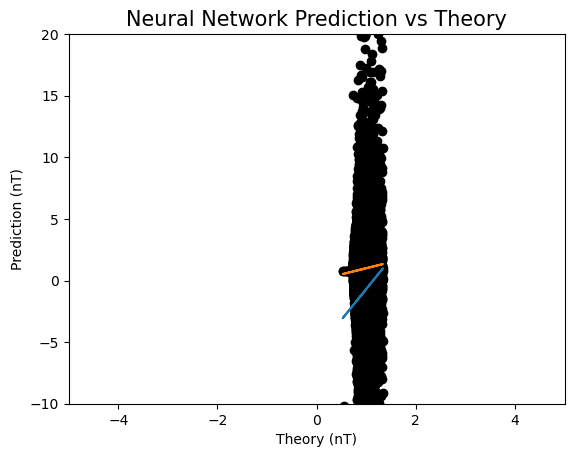

In [121]:
x = df4_pred1['theory'].values.flatten()
y = df4_pred1['predict'].values.flatten()
m, b, r, p, st_er = stats.linregress(x,y) 

yfit = [b + m * xi for xi in x]
yisx = [0 + 1 * xi for xi in x]
plt.plot(x, yfit)
plt.plot(x, yisx)

plt.scatter(y_pred, test_pred,  color='black')
plt.axis([-5, 5, -10, 20])
plt.xlabel("Theory (nT)")
plt.ylabel("Prediction (nT)")
plt.title("Neural Network Prediction vs Theory", fontsize=15)
# print(r, st_er)
print("r: {:.5f}, st_er: {:.6f}".format(r, st_er))
print("y = "+str(round(m,4))+"*x + "+str(round(b,4)))